# Multi-Layer Mode Comparison (Layers 25, 26, 27)

This notebook visualizes intervention effects across **multiple layers** with:
- **Add/Lesion**: Paired comparison (Δ = intv - baseline)
- **Rescue**: Triplet comparison (original → lesion → rescue)

Data source: `vm_results/results` experimental data with 3 layers

Data flow:
1. `05_mode_comparison_stats.ipynb` generates `mode_comparison_stats.csv`
2. This notebook loads that CSV and visualizes Add/Lesion + Rescue separately

In [1]:
import sys
sys.path.insert(0, '../..')

from pathlib import Path
import gzip

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import TwoSlopeNorm
from scipy import stats as scipy_stats
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Directories
VM_RESULTS_DIR = Path('../../vm_results/results')
OUTPUT_DIR = Path('../outputs/mode_comparison')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Set up clean plotting style
plt.rcParams.update({
    'figure.figsize': (16, 10),
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.2,
})

print('Setup complete!')
print(f'Looking for data in: {VM_RESULTS_DIR.resolve()}')

Setup complete!
Looking for data in: /Users/washieu/Desktop/MIT/F25/64610_project/rvs/vm_results/results


## 2. Load Stats Data

Load the pre-computed statistics from `mode_comparison_stats.csv`.

In [2]:
STATS_PATH = OUTPUT_DIR / 'mode_comparison_stats.csv'
if not STATS_PATH.exists():
    raise FileNotFoundError(f"Stats file not found: {STATS_PATH}. Run 05_mode_comparison_stats.ipynb first.")

stats = pd.read_csv(STATS_PATH)
print(f"Loaded stats: {len(stats)} rows from {STATS_PATH}")

# Rename for plotting consistency
stats = stats.rename(columns={'param_value': 'param', 'delta_mean': 'delta'})
stats['param'] = stats['param'].astype(float)

# Filter to Add and Lesion only for the paired plots
add_lesion_stats = stats[stats['mode'].isin(['add', 'lesion'])].copy()

layers = sorted(stats['layer'].unique())
localities = sorted(stats['locality'].unique())

print(f"\nLayers: {layers}")
print(f"Localities: {localities}")
print(f"Modes: {sorted(stats['mode'].unique())}")

display(stats.head(10))

Loaded stats: 54 rows from ../outputs/mode_comparison/mode_comparison_stats.csv

Layers: [np.int64(25), np.int64(26), np.int64(27)]
Localities: ['answer', 'cot']
Modes: ['add', 'lesion', 'rescue']


,mode,layer,param,param_type,locality,is_mock,n,delta,delta_median,mcnemar_p,mcnemar_net_gain,wilcoxon_p,sign_p,ttest_p
0,add,25,0.5,alpha,answer,False,25,0.04,0.0,1.0000,1.0,1.0000,1.0000,0.327287
1,add,25,1.0,alpha,answer,False,25,0.20,0.0,0.0625,5.0,0.0625,0.0625,0.021983
2,add,25,2.0,alpha,answer,False,25,0.16,0.0,0.1250,4.0,0.1250,0.1250,0.042896
3,add,26,0.5,alpha,answer,False,25,0.00,0.0,1.0000,NaN,1.0000,1.0000,NaN
4,add,26,1.0,alpha,answer,False,25,-0.04,0.0,1.0000,-1.0,1.0000,1.0000,0.327287
5,add,26,2.0,alpha,answer,False,25,0.00,0.0,1.0000,0.0,1.0000,1.0000,1.000000
6,add,27,0.5,alpha,answer,False,25,0.00,0.0,1.0000,0.0,1.0000,1.0000,1.000000
7,add,27,1.0,alpha,answer,False,25,0.00,0.0,1.0000,0.0,1.0000,1.0000,1.000000
8,add,27,2.0,alpha,answer,False,25,-0.04,0.0,1.0000,-1.0,1.0000,1.0000,0.663916
9,add,25,0.5,alpha,cot,False,25,0.12,0.0,0.3750,3.0,0.3750,0.3750,0.185045


## 3. Helper Functions

In [3]:
def format_pvalue(p: float) -> str:
    """Format p-value for display."""
    if pd.isna(p):
        return 'p=N/A'
    elif p < 0.001:
        return 'p<.001'
    elif p < 0.01:
        return f'p={p:.3f}'
    else:
        return f'p={p:.2f}'


def get_significance_stars(p: float) -> str:
    """Return significance stars based on p-value."""
    if pd.isna(p):
        return ''
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

print("Helper functions defined.")

Helper functions defined.


## 4. Add/Lesion Grid (3 Layers × 2 Modes)

Shows Add and Lesion effects across layers 25, 26, 27.

In [4]:
def plot_add_lesion_multilayer(
    data: pd.DataFrame,
    locality: str,
    layers_cfg: list = [25, 26, 27],
    baseline_acc: float = 0.65,
    title: str = None,
    save_path: Path | None = None,
    figsize: tuple = (14, 10)
) -> plt.Figure:
    """Create a 3×2 grid showing Add and Lesion effects across layers.
    
    Rows: Layers (25, 26, 27)
    Columns: Modes (Add, Lesion)
    """
    modes = ['add', 'lesion']
    mode_labels = {'add': 'Add (α)', 'lesion': 'Lesion (γ)'}
    params_cfg = [0.5, 1.0, 2.0]

    data_loc = data[data['locality'] == locality]
    if data_loc.empty:
        raise ValueError(f"No data for locality={locality}")

    # Find global min/max for consistent color scale
    vmin = data_loc['delta'].min()
    vmax = data_loc['delta'].max()
    abs_max = max(abs(vmin) if not pd.isna(vmin) else 0, abs(vmax) if not pd.isna(vmax) else 0)
    if abs_max == 0:
        abs_max = 0.1

    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(
        len(layers_cfg), len(modes) + 1,
        width_ratios=[1] * len(modes) + [0.08],
        wspace=0.15, hspace=0.25
    )

    cmap = sns.diverging_palette(10, 130, as_cmap=True)
    norm = TwoSlopeNorm(vmin=-abs_max, vcenter=0, vmax=abs_max)

    im = None
    for row_idx, layer in enumerate(layers_cfg):
        for col_idx, mode in enumerate(modes):
            ax = fig.add_subplot(gs[row_idx, col_idx])

            cell_data = data_loc[(data_loc['layer'] == layer) & (data_loc['mode'] == mode)]

            values = []
            pvalues = []
            for p in params_cfg:
                row = cell_data[cell_data['param'] == p]
                if len(row) > 0:
                    values.append(row['delta'].values[0] if not pd.isna(row['delta'].values[0]) else 0.0)
                    pvalues.append(row['mcnemar_p'].values[0] if 'mcnemar_p' in row.columns else np.nan)
                else:
                    values.append(0.0)
                    pvalues.append(np.nan)

            heatmap_data = np.array([values])
            im = ax.imshow(heatmap_data, cmap=cmap, norm=norm, aspect='auto')

            # Add value annotations
            for i, (val, pval) in enumerate(zip(values, pvalues)):
                text_color = 'white' if abs(val) > abs_max * 0.5 else 'black'
                stars = get_significance_stars(pval)
                is_significant = pval < 0.05 if not pd.isna(pval) else False

                delta_text = f'{val:+.2f}{stars}'
                fontweight = 'bold' if is_significant else 'semibold'
                ax.text(i, -0.15, delta_text, ha='center', va='center',
                        fontsize=11, color=text_color, fontweight=fontweight)

                pval_text = format_pvalue(pval)
                pval_fontweight = 'bold' if is_significant else 'normal'
                ax.text(i, 0.25, pval_text, ha='center', va='center',
                        fontsize=9, color=text_color, fontweight=pval_fontweight)

            ax.set_xticks(range(len(params_cfg)))
            ax.set_yticks([])

            if row_idx == len(layers_cfg) - 1:
                ax.set_xticklabels([str(p) for p in params_cfg], fontsize=10)
                ax.set_xlabel('Parameter Value', fontsize=11)
            else:
                ax.set_xticklabels([])

            if row_idx == 0:
                ax.set_title(mode_labels[mode], fontsize=13, fontweight='bold', pad=10)

            if col_idx == 0:
                ax.set_ylabel(f'Layer {layer}', fontsize=12, fontweight='bold')

            for spine in ax.spines.values():
                spine.set_visible(True)
                spine.set_linewidth(0.5)
                spine.set_color('#cccccc')

    # Colorbar
    cbar_ax = fig.add_subplot(gs[:, -1])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Δ Answer Accuracy\n(Intervention − Baseline)', fontsize=11, labelpad=12)

    # Title
    if title is None:
        title = f'{locality.upper()} Locality: Add/Lesion Effects (Layers 25-27)'
    fig.suptitle(title, fontsize=16, fontweight='bold', y=1.02)

    # Subtitle
    subtitle = (
        f'Baseline Accuracy: {baseline_acc:.1%}\n'
        'Δ = Intervention Accuracy − Baseline Accuracy\n'
        "p-values: McNemar's Test | * p<0.05, ** p<0.01, *** p<0.001 | Bold = Significant"
    )
    fig.text(0.5, 0.94, subtitle, ha='center', fontsize=10, style='italic', color='#555555')

    plt.tight_layout(rect=[0, 0, 1, 0.88])

    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Saved to {save_path}")

    return fig

print("Add/Lesion multi-layer plotting function defined.")

Add/Lesion multi-layer plotting function defined.


Saved to ../outputs/mode_comparison/multilayer_add_lesion_cot.pdf


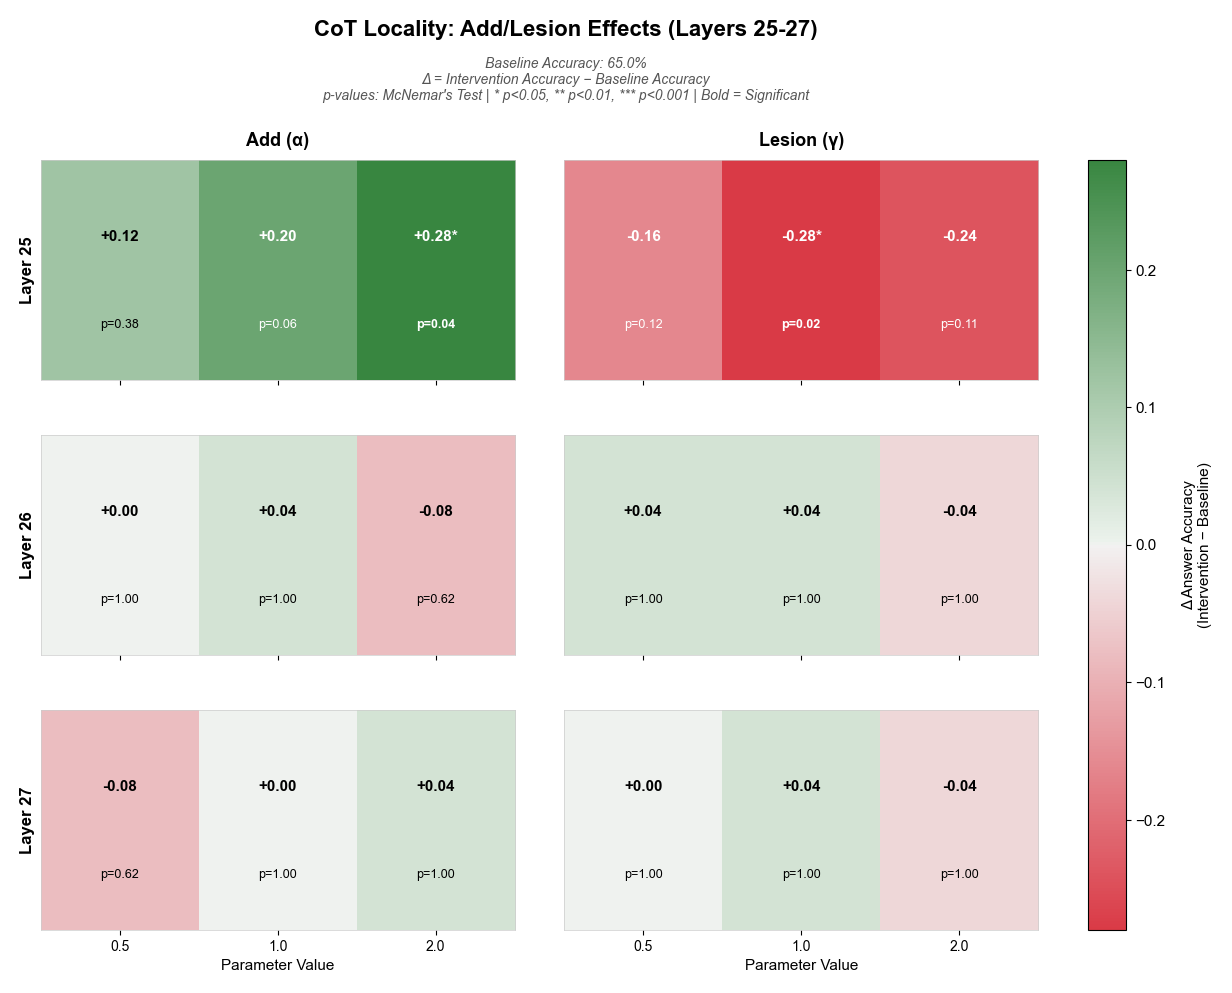

In [48]:
# COT Locality: Add/Lesion
if 'cot' in localities:
    fig_cot_al = plot_add_lesion_multilayer(
        add_lesion_stats,
        locality='cot',
        layers_cfg=layers,
        baseline_acc=0.65,
        title='CoT Locality: Add/Lesion Effects (Layers 25-27)',
        save_path=OUTPUT_DIR / 'multilayer_add_lesion_cot.pdf',
    )
    plt.show()

Saved to ../outputs/mode_comparison/multilayer_add_lesion_answer.pdf


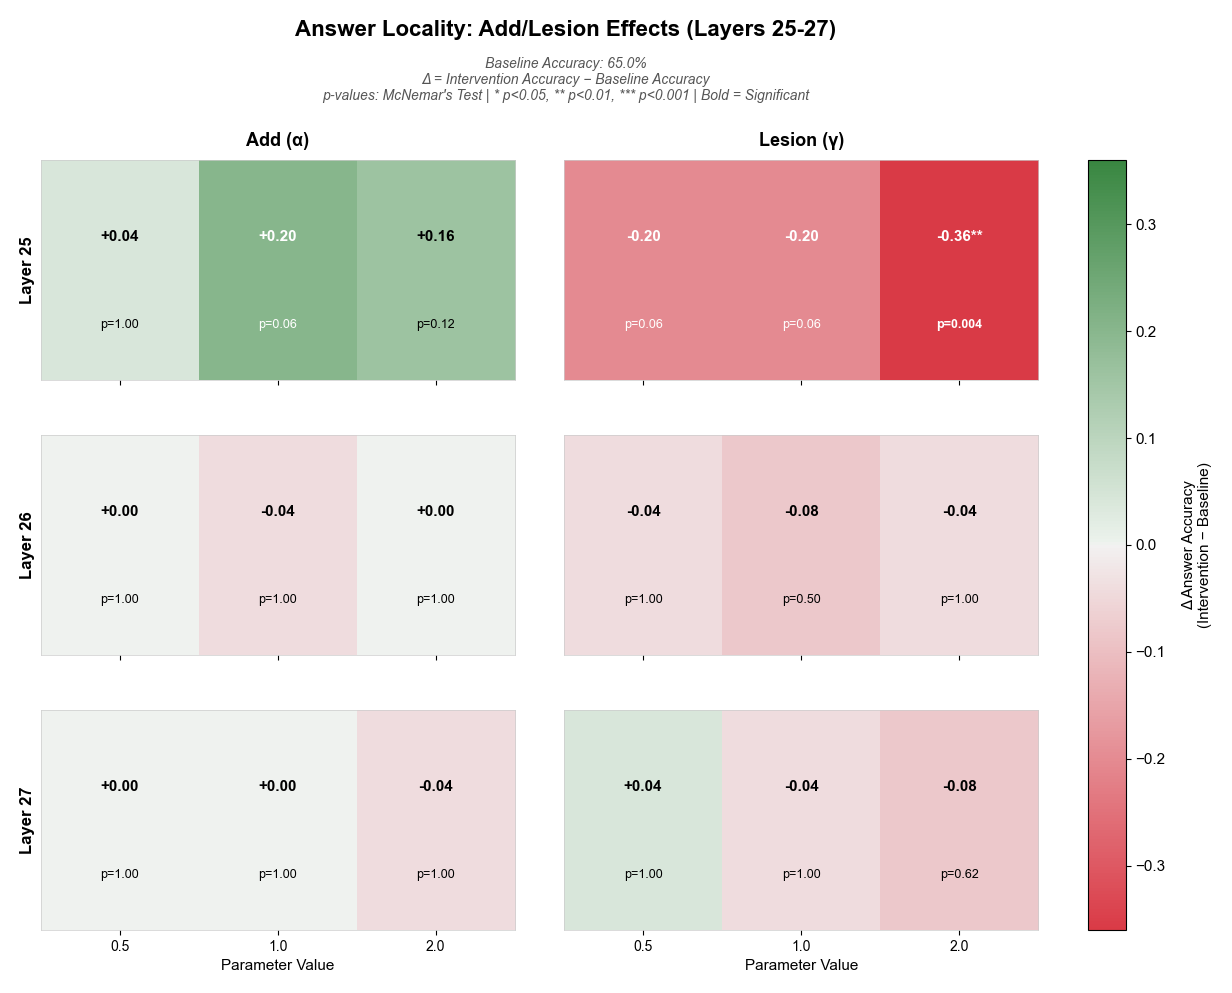

In [6]:
# Answer Locality: Add/Lesion
if 'answer' in localities:
    fig_answer_al = plot_add_lesion_multilayer(
        add_lesion_stats,
        locality='answer',
        layers_cfg=layers,
        baseline_acc=0.65,
        title='Answer Locality: Add/Lesion Effects (Layers 25-27)',
        save_path=OUTPUT_DIR / 'multilayer_add_lesion_answer.pdf',
    )
    plt.show()

## 5. Load Raw Rescue Data for Triplet Analysis

To compute rescue triplet statistics (original, lesion, rescue), we need to load the raw per-example CSVs.

In [7]:
def find_exp_dir(locality: str, base_dir: Path = VM_RESULTS_DIR) -> Path:
    """Find the experiment directory for a given locality."""
    pattern = f"*__{locality}_locality_*"
    exp_dirs = sorted(base_dir.glob(pattern))
    if not exp_dirs:
        raise FileNotFoundError(f"No experiment directory matching {pattern} in {base_dir}")
    return exp_dirs[-1]


def load_rescue_triplet_data(locality: str) -> pd.DataFrame:
    """Load rescue CSV files and compute triplet statistics."""
    exp_dir = find_exp_dir(locality)
    print(f"Loading rescue data from: {exp_dir}")
    
    # Find all rescue files
    runs_dirs = list(exp_dir.glob('*/runs'))
    if not runs_dirs:
        print(f"No runs directories found in {exp_dir}")
        return pd.DataFrame()
    
    all_rescue_data = []
    
    for runs_dir in runs_dirs:
        rescue_files = list(runs_dir.glob('rescue_*.csv.gz'))
        
        for f in rescue_files:
            try:
                # Parse filename for layer, gamma, beta
                name = f.stem.replace('.csv', '')
                parts = name.split('_')
                
                layer = None
                gamma = None
                beta = None
                
                for part in parts:
                    if part.startswith('L') and part[1:].isdigit():
                        layer = int(part[1:])
                    elif part.startswith('G'):
                        gamma = float(part[1:])
                    elif part.startswith('B'):
                        beta = float(part[1:])
                
                if layer is None or beta is None:
                    continue
                
                # Load data
                with gzip.open(f, 'rt') as gz:
                    df = pd.read_csv(gz)
                
                # Check for triplet columns
                has_triplet = (
                    'baseline_answer_correct' in df.columns and
                    'lesion_answer_correct' in df.columns and
                    'rescue_answer_correct' in df.columns
                )
                
                if has_triplet:
                    # Compute triplet stats
                    n = len(df)
                    acc_original = df['baseline_answer_correct'].mean()
                    acc_lesion = df['lesion_answer_correct'].mean()
                    acc_rescue = df['rescue_answer_correct'].mean()
                    
                    # Recovery rate
                    if acc_original > acc_lesion:
                        recovery_rate = (acc_rescue - acc_lesion) / (acc_original - acc_lesion)
                    else:
                        recovery_rate = np.nan
                    
                    # McNemar for lesion vs rescue
                    lesion_wrong_rescue_right = ((df['lesion_answer_correct'] == 0) & (df['rescue_answer_correct'] == 1)).sum()
                    lesion_right_rescue_wrong = ((df['lesion_answer_correct'] == 1) & (df['rescue_answer_correct'] == 0)).sum()
                    
                    if lesion_wrong_rescue_right + lesion_right_rescue_wrong > 0:
                        try:
                            mcnemar_p = scipy_stats.binomtest(
                                min(lesion_wrong_rescue_right, lesion_right_rescue_wrong),
                                lesion_wrong_rescue_right + lesion_right_rescue_wrong,
                                0.5
                            ).pvalue
                        except:
                            mcnemar_p = np.nan
                    else:
                        mcnemar_p = np.nan
                    
                    all_rescue_data.append({
                        'locality': locality,
                        'layer': layer,
                        'gamma': gamma if gamma else 1.0,
                        'beta': beta,
                        'n': n,
                        'acc_original': acc_original,
                        'acc_lesion': acc_lesion,
                        'acc_rescue': acc_rescue,
                        'recovery_rate': recovery_rate,
                        'mcnemar_rescue_p': mcnemar_p,
                    })
                    
            except Exception as e:
                print(f"Error loading {f}: {e}")
    
    return pd.DataFrame(all_rescue_data)


# Load rescue data for both localities
rescue_dfs = []
for loc in localities:
    try:
        df = load_rescue_triplet_data(loc)
        if not df.empty:
            rescue_dfs.append(df)
            print(f"  Loaded {len(df)} rescue triplets for {loc}")
    except Exception as e:
        print(f"  Could not load rescue data for {loc}: {e}")

if rescue_dfs:
    rescue_triplet_stats = pd.concat(rescue_dfs, ignore_index=True)
    print(f"\nTotal rescue triplet rows: {len(rescue_triplet_stats)}")
    display(rescue_triplet_stats)
else:
    rescue_triplet_stats = pd.DataFrame()
    print("No rescue triplet data found.")

Loading rescue data from: ../../vm_results/results/data__answer_locality_20251203_191746
  Loaded 27 rescue triplets for answer
Loading rescue data from: ../../vm_results/results/data__cot_locality_20251203_191746
  Loaded 27 rescue triplets for cot

Total rescue triplet rows: 54


,locality,layer,gamma,beta,n,acc_original,acc_lesion,acc_rescue,recovery_rate,mcnemar_rescue_p
0,answer,27,2.0,1.0,25,0.64,0.52,0.40,-1.000000,0.375000
1,answer,26,2.0,2.0,25,0.68,0.68,0.68,NaN,NaN
2,answer,25,0.5,1.0,25,0.72,0.44,0.72,1.000000,0.015625
3,answer,25,1.0,1.0,25,0.56,0.28,0.48,0.714286,0.125000
4,answer,26,2.0,0.5,25,0.60,0.64,0.72,NaN,0.500000
5,answer,26,1.0,1.0,25,0.68,0.60,0.60,0.000000,NaN
6,answer,27,0.5,2.0,25,0.64,0.72,0.64,NaN,0.500000
7,answer,25,2.0,0.5,25,0.68,0.36,0.36,0.000000,NaN
8,answer,27,1.0,2.0,25,0.80,0.76,0.76,0.000000,1.000000
9,answer,26,0.5,1.0,25,0.60,0.52,0.52,0.000000,NaN


## 6. Rescue Triplet Visualization (Multi-Layer)

Shows original baseline, lesion damage, and rescue recovery for each layer.

In [43]:
def plot_rescue_triplet_multilayer(
    data: pd.DataFrame,
    locality: str,
    layers_cfg: list = [25, 26, 27],
    baseline_acc: float = 0.65,
    title: str = None,
    save_path: Path | None = None,
    figsize: tuple = (16, 12)
) -> plt.Figure:
    """Create rescue triplet visualization for multiple layers.
    
    One row per layer, showing lesion vs rescue at each beta.
    """
    loc_data = data[data['locality'] == locality].copy()
    if loc_data.empty:
        print(f"No rescue data for locality={locality}")
        return None
    
    # Filter to gamma=1.0 if available
    gammas = sorted(loc_data['gamma'].unique())
    target_gamma = 1.0 if 1.0 in gammas else gammas[0]
    loc_data = loc_data[loc_data['gamma'] == target_gamma]
    
    betas = sorted(loc_data['beta'].unique())
    n_betas = len(betas)
    
    fig, axes = plt.subplots(len(layers_cfg), 1, figsize=figsize, sharex=True)
    if len(layers_cfg) == 1:
        axes = [axes]
    
    width = 0.35
    
    for ax_idx, (ax, layer) in enumerate(zip(axes, layers_cfg)):
        layer_data = loc_data[loc_data['layer'] == layer]
        
        if layer_data.empty:
            ax.text(0.5, 0.5, f'No data for Layer {layer}', ha='center', va='center', transform=ax.transAxes)
            continue
        
        original_acc = layer_data['acc_original'].mean()
        
        # Plot original baseline
        ax.axhline(y=original_acc, color='#2E86AB', linestyle='--', linewidth=2.5,
                   label=f'Original ({original_acc:.1%})')
        
        x = np.arange(n_betas)
        
        lesion_accs = []
        rescue_accs = []
        recovery_rates = []
        rescue_pvals = []
        
        for beta in betas:
            row = layer_data[layer_data['beta'] == beta]
            if len(row) > 0:
                lesion_accs.append(row['acc_lesion'].values[0])
                rescue_accs.append(row['acc_rescue'].values[0])
                recovery_rates.append(row['recovery_rate'].values[0])
                rescue_pvals.append(row['mcnemar_rescue_p'].values[0])
            else:
                lesion_accs.append(np.nan)
                rescue_accs.append(np.nan)
                recovery_rates.append(np.nan)
                rescue_pvals.append(np.nan)
        
        # Plot bars
        ax.bar(x - width/2, lesion_accs, width, label='Lesioned',
               color='#E74C3C', alpha=0.85, edgecolor='black', linewidth=0.8)
        ax.bar(x + width/2, rescue_accs, width, label='Rescued',
               color='#27AE60', alpha=0.85, edgecolor='black', linewidth=0.8)
        
        # Annotations
        for i, (lesion_acc, rescue_acc, recovery, pval) in enumerate(zip(
            lesion_accs, rescue_accs, recovery_rates, rescue_pvals
        )):
            if not pd.isna(lesion_acc):
                ax.text(i - width/2, lesion_acc - 0.1, f'{lesion_acc:.1%}',
                        ha='center', va='bottom', fontsize=10, fontweight='semibold')
            
            if not pd.isna(rescue_acc):
                stars = get_significance_stars(pval)
                is_sig = pval < 0.05 if not pd.isna(pval) else False
                fontweight = 'bold' if is_sig else 'semibold'
                ax.text(i + width/2, rescue_acc - 0.1, f'{rescue_acc:.1%}{stars}',
                        ha='center', va='bottom', fontsize=10, fontweight=fontweight)
        
        ax.set_ylabel(f'Layer {layer}\nAccuracy', fontsize=11, fontweight='bold')
        ax.set_ylim(0, 1.05)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
        ax.legend(loc='upper left', fontsize=10, framealpha=0.95)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # X-axis labels on bottom plot
    axes[-1].set_xticks(np.arange(n_betas))
    axes[-1].set_xticklabels([f'β = {b}' for b in betas], fontsize=12)
    axes[-1].set_xlabel('Rescue Strength (β)', fontsize=13)
    
    # Title
    if title is None:
        title = f'{locality.upper()} Locality: Rescue Triplet (γ={target_gamma})'
    fig.suptitle(title, fontsize=16, fontweight='bold', y=1.01)
    
    # Subtitle
    subtitle = (
        f'Baseline Accuracy: ~{baseline_acc:.1%} | Lesion γ={target_gamma}\n'
        'Dashed line = Original | Bars = Lesioned vs Rescued\n'
        "* p<0.05, ** p<0.01, *** p<0.001 (McNemar's Test)"
    )
    fig.text(0.52, -0.03, subtitle, ha='center', fontsize=10, style='italic', color='#555555')
    
    plt.tight_layout()
    
    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Saved to {save_path}")
    
    return fig

print("Rescue triplet multi-layer plotting function defined.")

Rescue triplet multi-layer plotting function defined.


Saved to ../outputs/mode_comparison/multilayer_rescue_triplet_cot.pdf


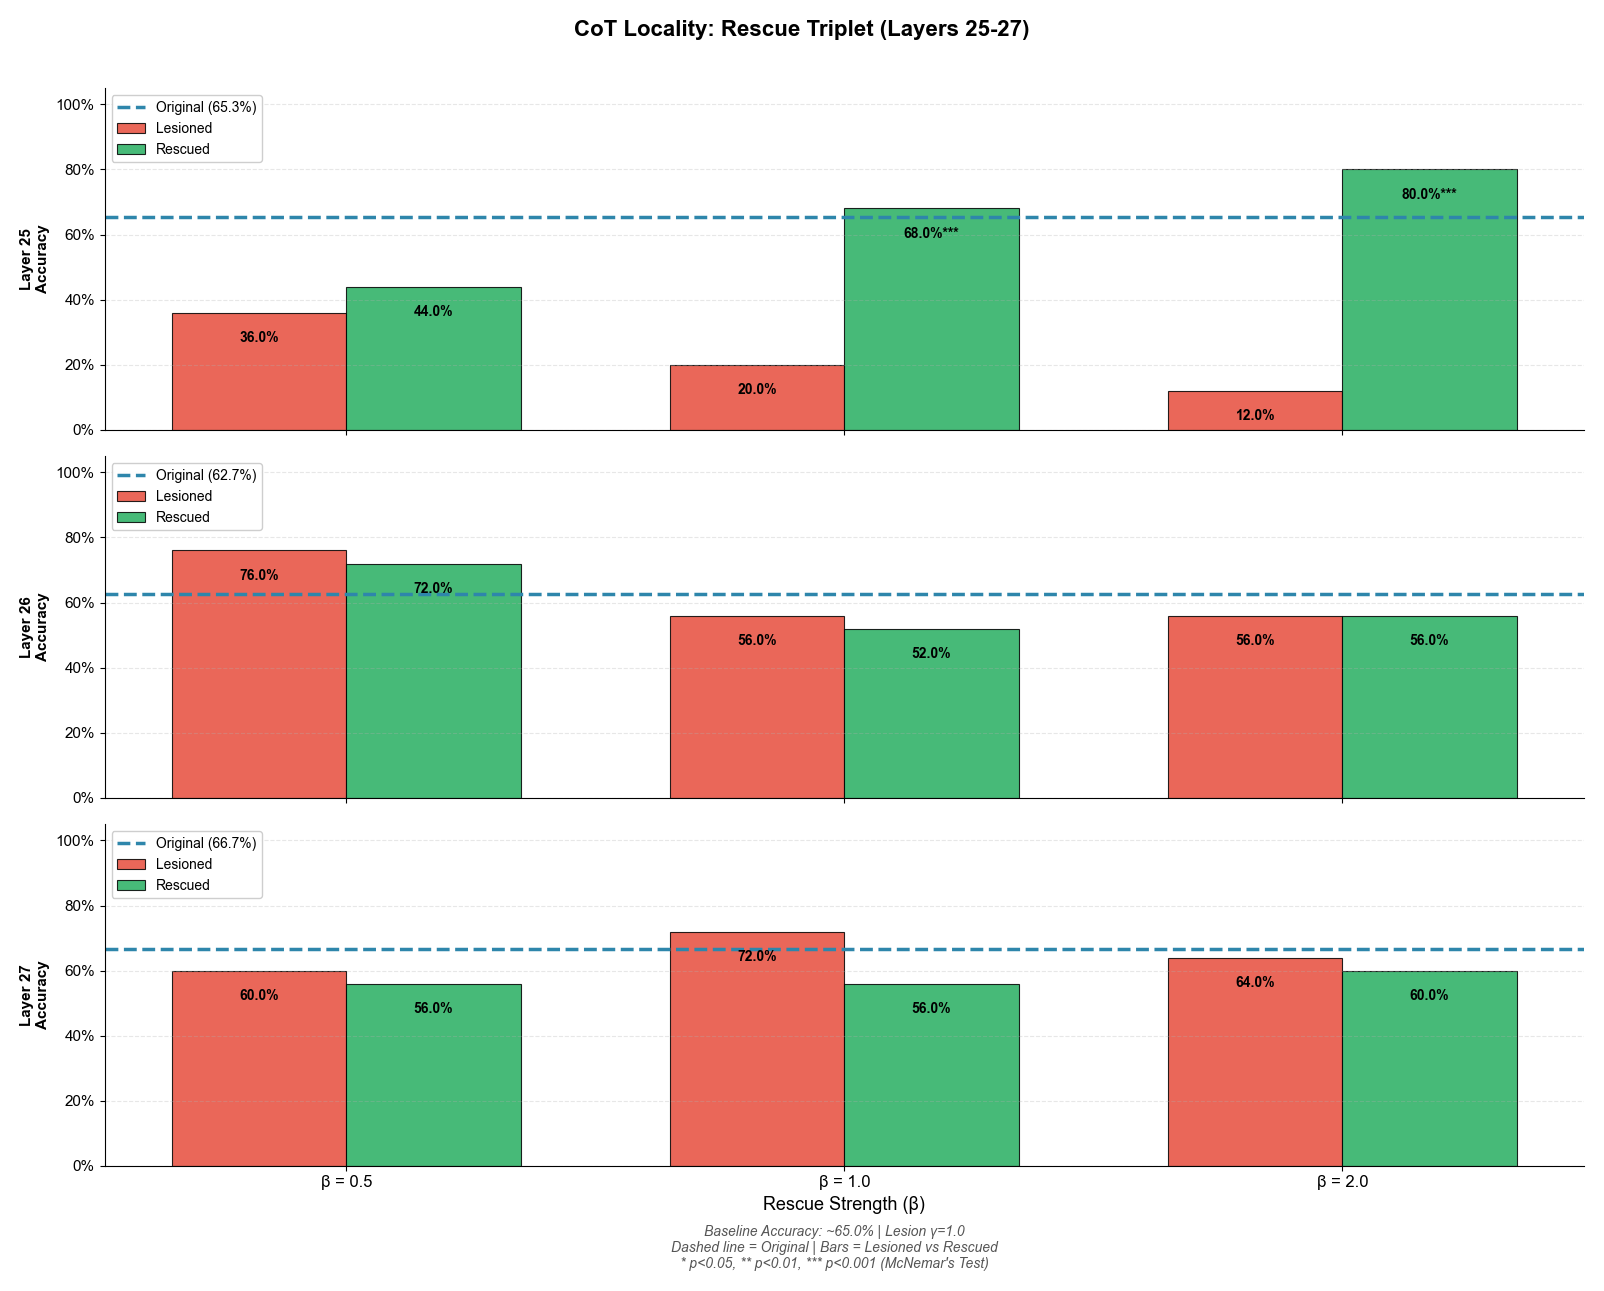

In [46]:
# COT Locality: Rescue Triplet
if not rescue_triplet_stats.empty and 'cot' in rescue_triplet_stats['locality'].values:
    fig_cot_rescue = plot_rescue_triplet_multilayer(
        rescue_triplet_stats,
        locality='cot',
        layers_cfg=layers,
        baseline_acc=0.65,
        title='CoT Locality: Rescue Triplet (Layers 25-27)',
        save_path=OUTPUT_DIR / 'multilayer_rescue_triplet_cot.pdf',
    )
    plt.show()
else:
    print("No COT rescue triplet data available.")

Saved to ../outputs/mode_comparison/multilayer_rescue_triplet_answer.pdf


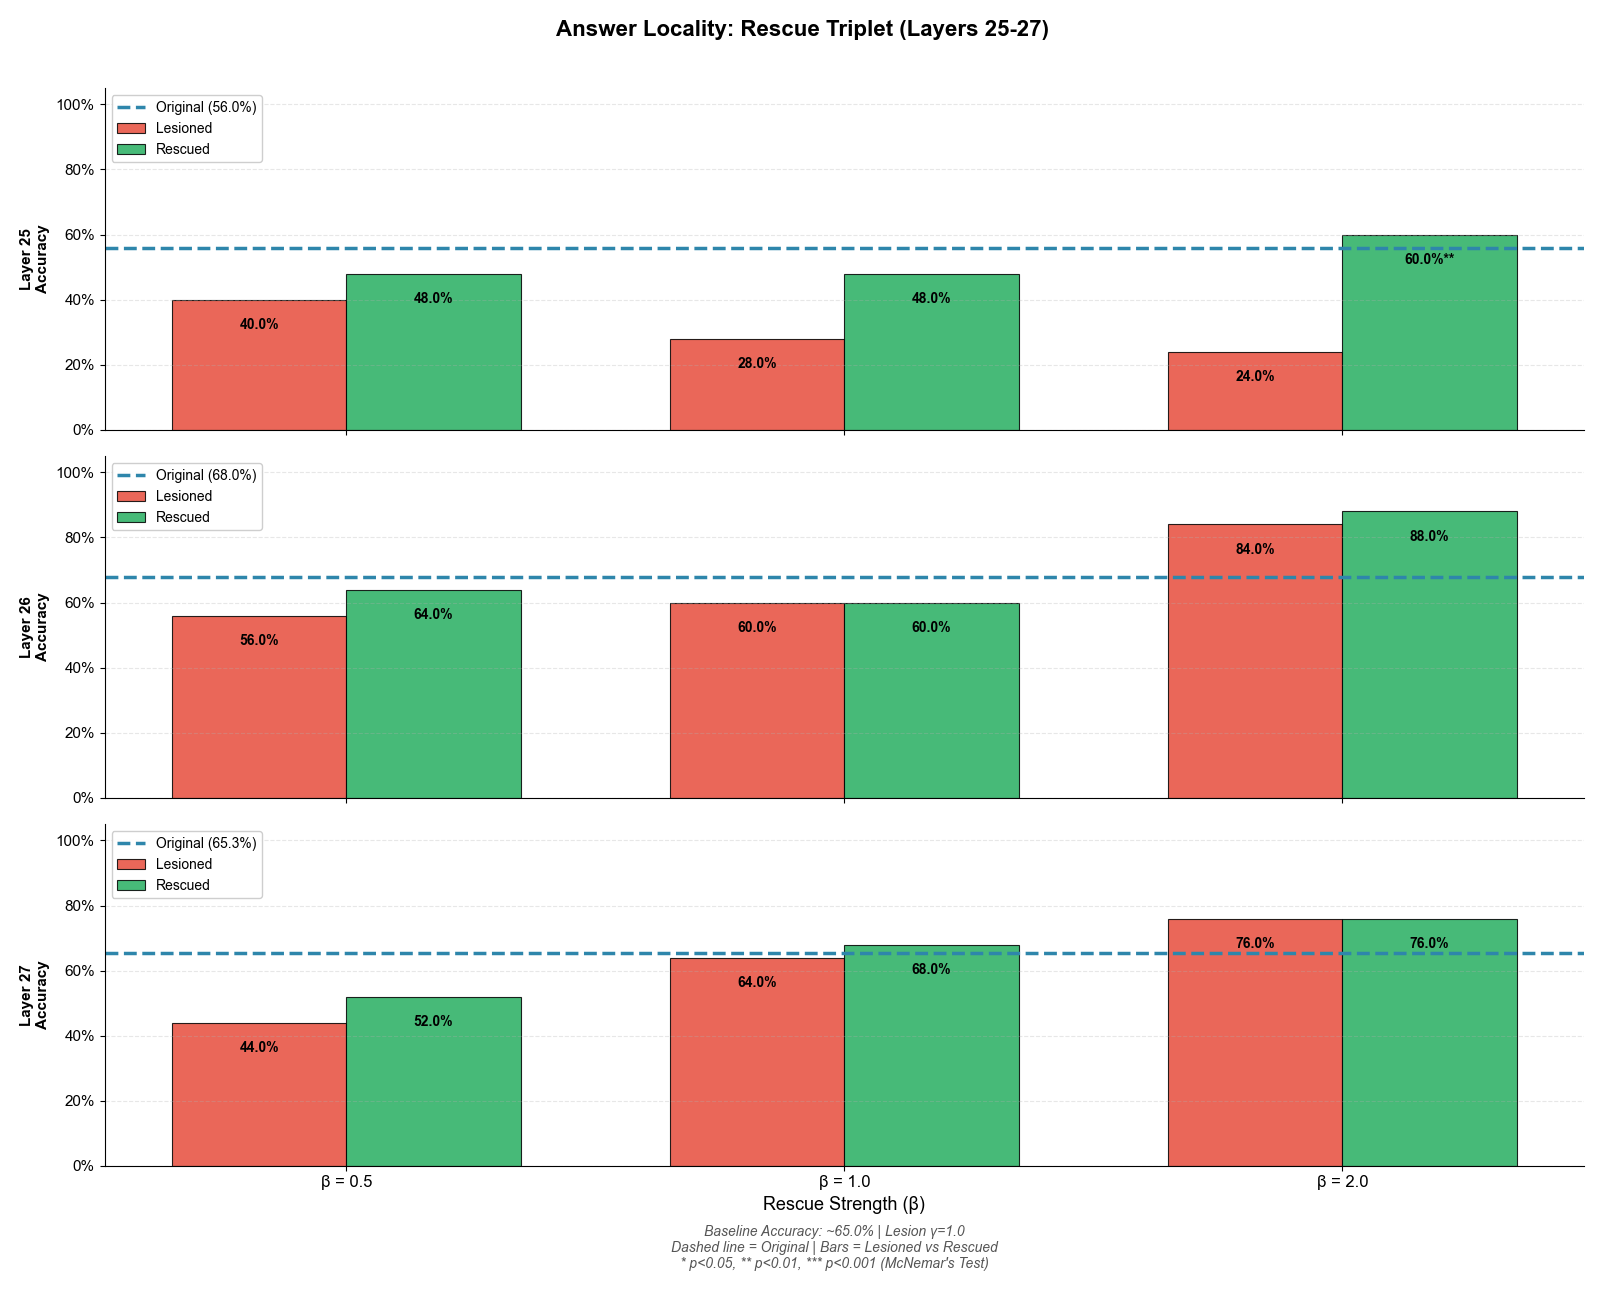

In [47]:
# Answer Locality: Rescue Triplet
if not rescue_triplet_stats.empty and 'answer' in rescue_triplet_stats['locality'].values:
    fig_answer_rescue = plot_rescue_triplet_multilayer(
        rescue_triplet_stats,
        locality='answer',
        layers_cfg=layers,
        baseline_acc=0.65,
        title='Answer Locality: Rescue Triplet (Layers 25-27)',
        save_path=OUTPUT_DIR / 'multilayer_rescue_triplet_answer.pdf',
    )
    plt.show()
else:
    print("No Answer rescue triplet data available.")

## 7. Summary Tables

In [11]:
print("\n=== Add/Lesion Summary (All Layers) ===")
summary_al = add_lesion_stats[['mode', 'layer', 'param', 'locality', 'delta', 'mcnemar_p']].copy()
summary_al['significant'] = summary_al['mcnemar_p'].apply(
    lambda p: '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else ''))
)
summary_al = summary_al.sort_values(['locality', 'layer', 'mode', 'param'])
display(summary_al)

if not rescue_triplet_stats.empty:
    print("\n=== Rescue Triplet Summary (All Layers) ===")
    summary_rescue = rescue_triplet_stats[[
        'locality', 'layer', 'beta', 'acc_original', 'acc_lesion', 
        'acc_rescue', 'recovery_rate', 'mcnemar_rescue_p'
    ]].copy()
    summary_rescue['significant'] = summary_rescue['mcnemar_rescue_p'].apply(
        lambda p: '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else ''))
    )
    summary_rescue = summary_rescue.sort_values(['locality', 'layer', 'beta'])
    display(summary_rescue)


=== Add/Lesion Summary (All Layers) ===


,mode,layer,param,locality,delta,mcnemar_p,significant
0,add,25,0.5,answer,0.04,1.000000,
1,add,25,1.0,answer,0.20,0.062500,
2,add,25,2.0,answer,0.16,0.125000,
18,lesion,25,0.5,answer,-0.20,0.062500,
19,lesion,25,1.0,answer,-0.20,0.062500,
20,lesion,25,2.0,answer,-0.36,0.003906,**
3,add,26,0.5,answer,0.00,1.000000,
4,add,26,1.0,answer,-0.04,1.000000,
5,add,26,2.0,answer,0.00,1.000000,
21,lesion,26,0.5,answer,-0.04,1.000000,



=== Rescue Triplet Summary (All Layers) ===


,locality,layer,beta,acc_original,acc_lesion,acc_rescue,recovery_rate,mcnemar_rescue_p,significant
7,answer,25,0.5,0.68,0.36,0.36,0.000000,NaN,
17,answer,25,0.5,0.68,0.56,0.64,0.666667,0.500000,
18,answer,25,0.5,0.60,0.40,0.48,0.400000,0.625000,
2,answer,25,1.0,0.72,0.44,0.72,1.000000,0.015625,*
3,answer,25,1.0,0.56,0.28,0.48,0.714286,0.125000,
21,answer,25,1.0,0.68,0.24,0.64,0.909091,0.001953,**
11,answer,25,2.0,0.52,0.16,0.56,1.111111,0.001953,**
14,answer,25,2.0,0.52,0.36,0.68,2.000000,0.007812,**
15,answer,25,2.0,0.52,0.24,0.60,1.285714,0.003906,**
4,answer,26,0.5,0.60,0.64,0.72,NaN,0.500000,


## 8. Interpretation Guide

### Add/Lesion (Paired Comparison)

**Δ Answer Accuracy = Intervention Accuracy − Baseline Accuracy**

| Mode | Expected Pattern | Interpretation |
|------|-----------------|----------------|
| Add | Positive Δ, dose-dependent | Reasoning direction is **sufficient** |
| Lesion | Negative Δ, dose-dependent | Reasoning direction is **necessary** |

### Rescue Triplet

| Metric | Description |
|--------|-------------|
| **acc_original** | Performance without intervention |
| **acc_lesion** | Performance after lesion (degraded) |
| **acc_rescue** | Performance after lesion + rescue (recovered) |
| **recovery_rate** | (rescue - lesion) / (original - lesion) |

**Expected pattern**: Recovery rate increases with β, demonstrating causal reversibility.

### Statistical Test

- **McNemar's Test**: For paired binary outcomes
- `*` p < 0.05, `**` p < 0.01, `***` p < 0.001